In [23]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import torch

from simulate.simulate import simulate

from inference.loss_minibatch import LossMinibatch
from inference.train_minibatch import train_minibatch
from inference.flows import NormalizingFlow

from plot.plot_hist_loss import plot_loss
from plot.plot_posterior import plot_posterior
from plot.loss_tracker import LossTracker

In [9]:
%config InlineBackend.figure_format = "retina"
sns.set()

In [10]:
data, truth = simulate(use_torch=True)

# Test 1

In [12]:
run_name = 'artificial_mini_batch'
z_flow, theta_flow, hist_loss = train_minibatch(
    data, 
    optimizer_name='Adam',
    batch_size=1000, 
    n_sample=100,
    initial_lr=0.005, 
    flow_length=40, 
    n_epochs=5000)

  0%|          | 0/5000 [00:00<?, ?it/s]

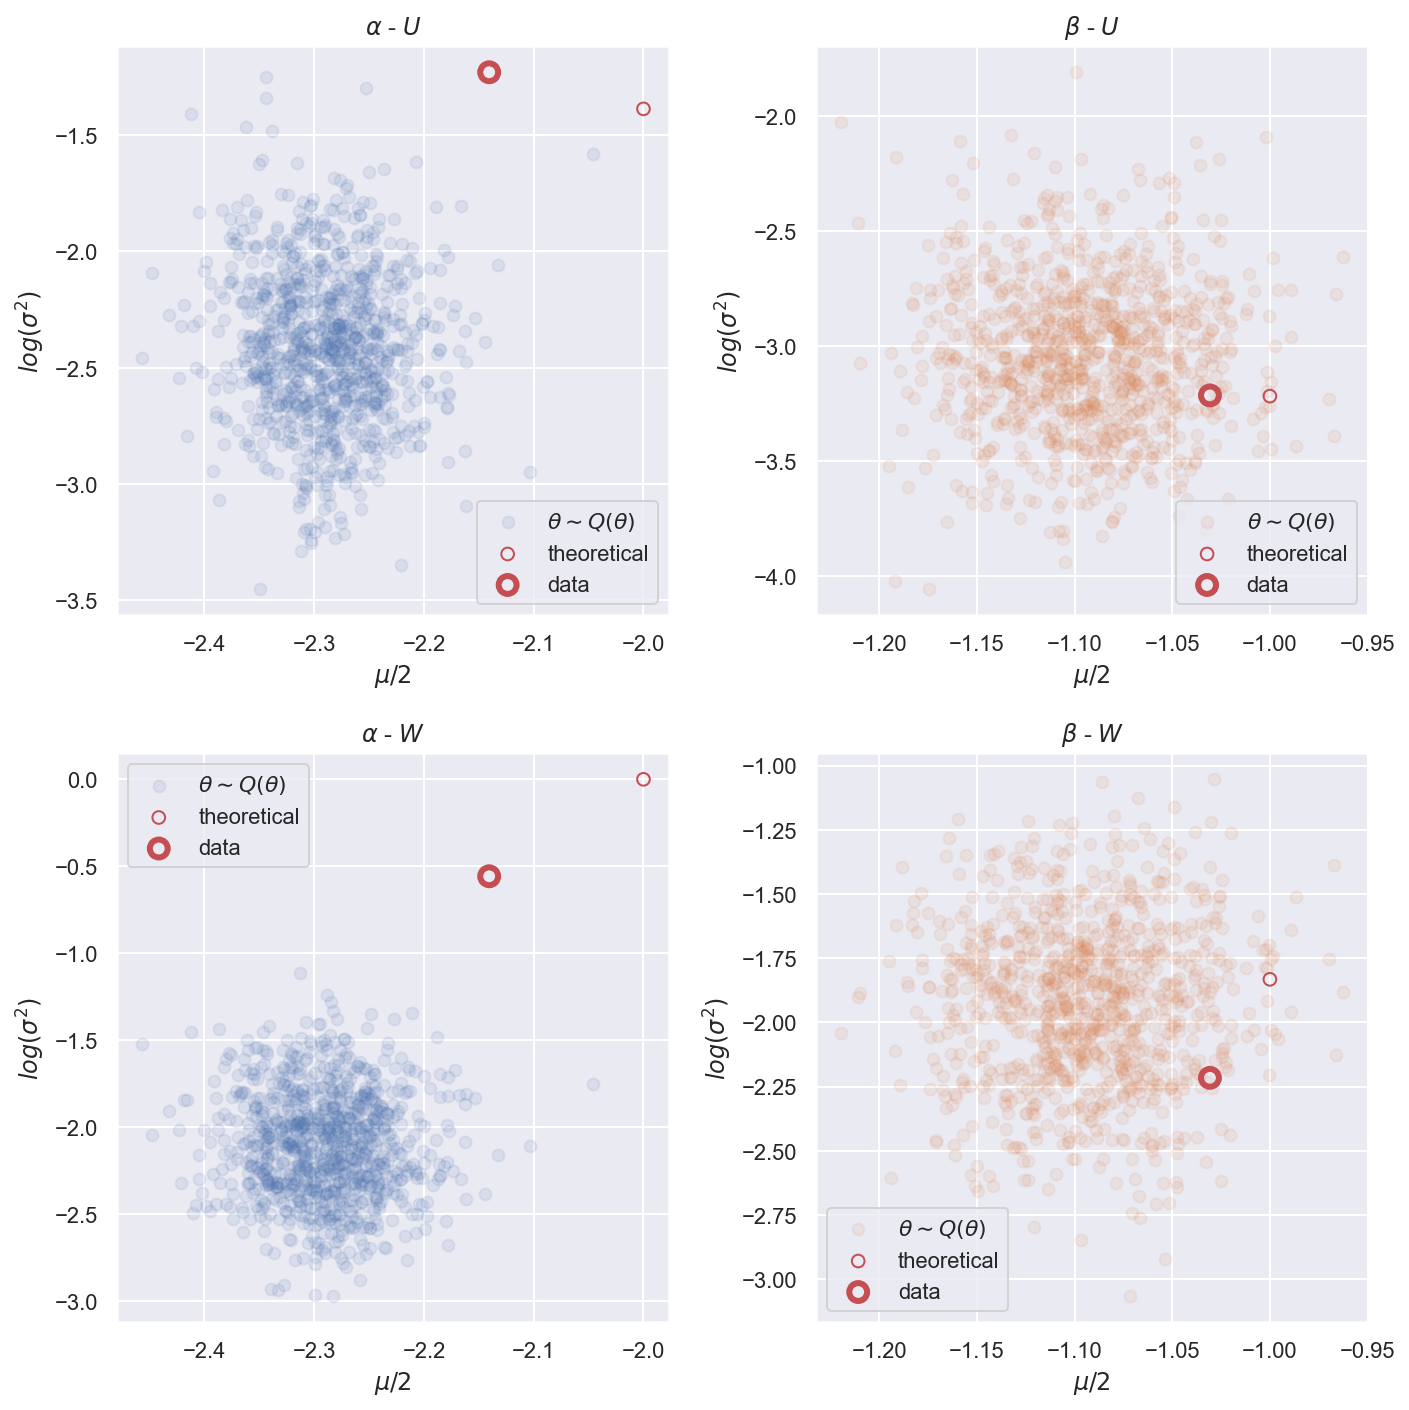

In [13]:
plot_posterior(theta_flow=theta_flow, 
               truth=truth, 
               name=run_name)

In [ ]:
z_flow.save(run_name) 
theta_flow.save(run_name)

# Test 2

In [7]:
run_name = "artificial_minibatch_rmsprop_opt"

In [8]:
z_flow, theta_flow, hist_loss = train_minibatch(
    data, 
    optimizer_name='RMSprop',
    batch_size=1000, 
    n_sample=50,
    initial_lr=0.001, 
    flow_length=33, 
    n_epochs=5000)

  0%|          | 0/5000 [00:00<?, ?it/s]

In [9]:
z_flow.save(run_name) 
theta_flow.save(run_name)

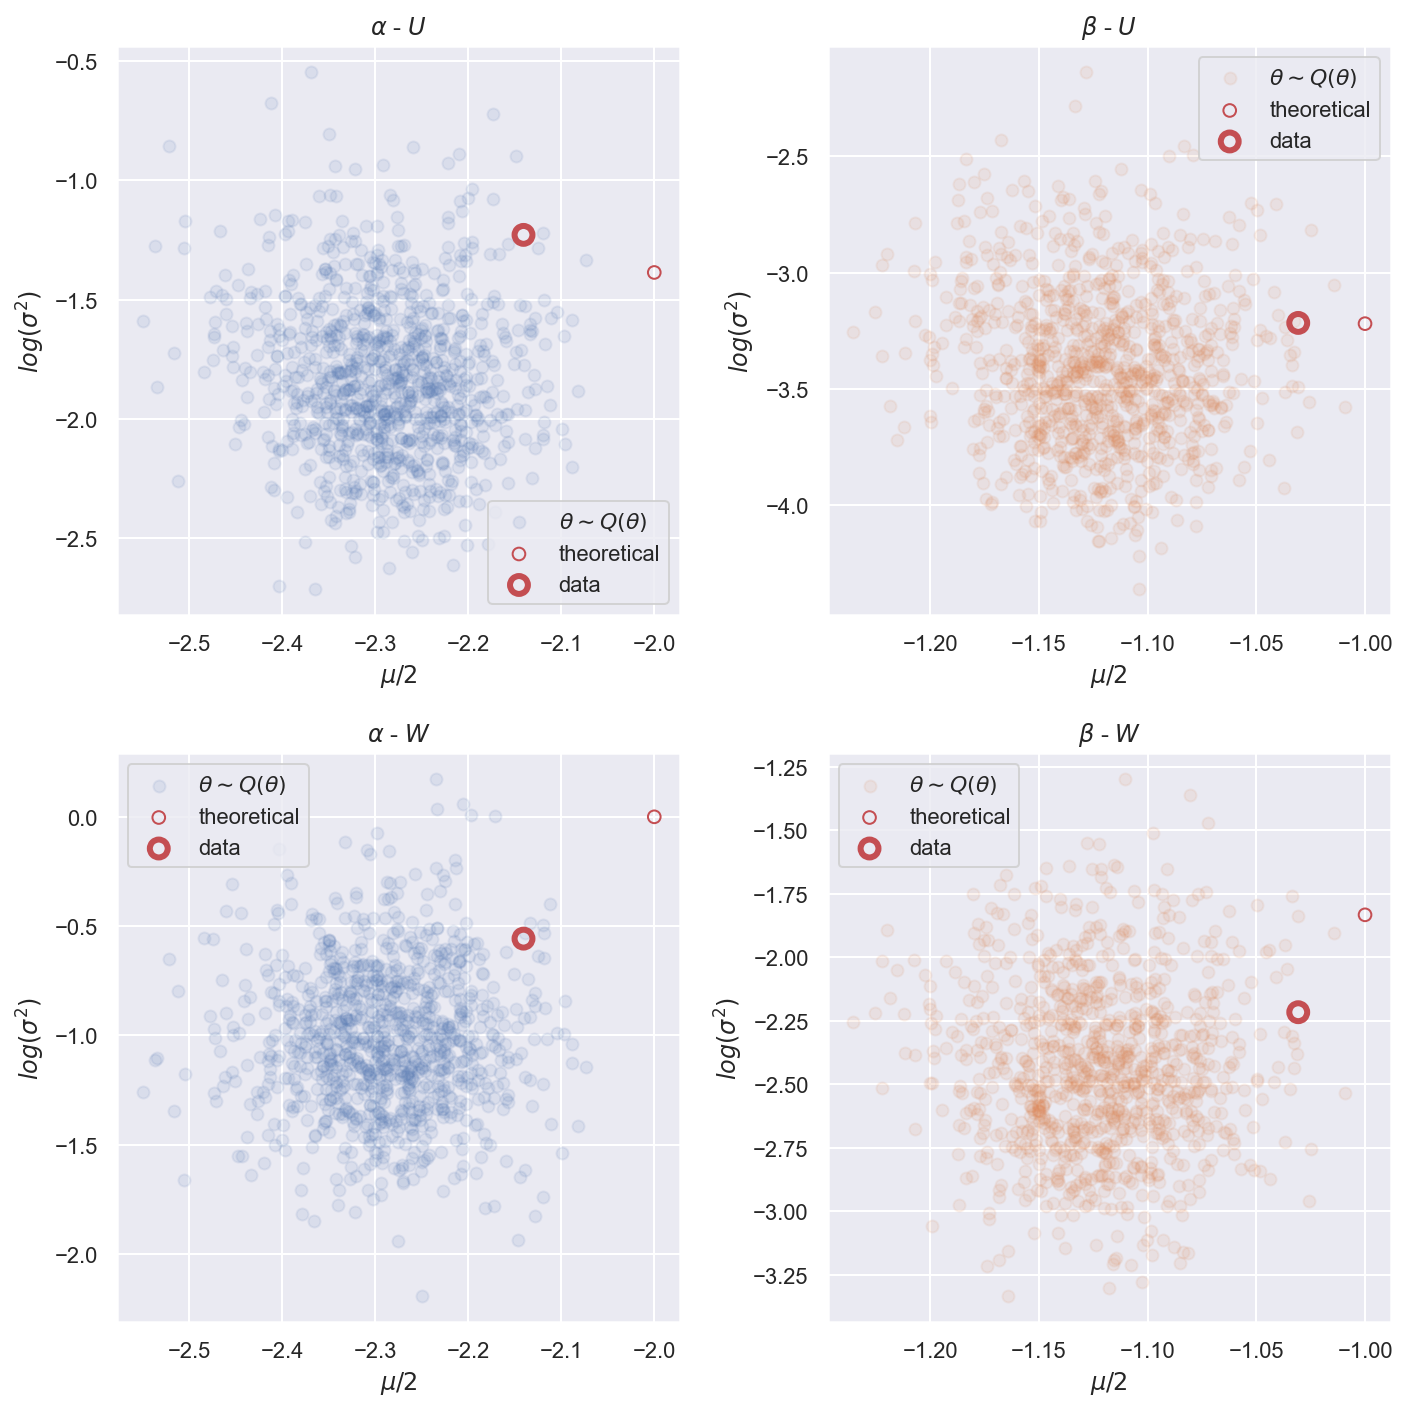

In [10]:
plot_posterior(theta_flow=theta_flow, 
               truth=truth, 
               name=run_name)

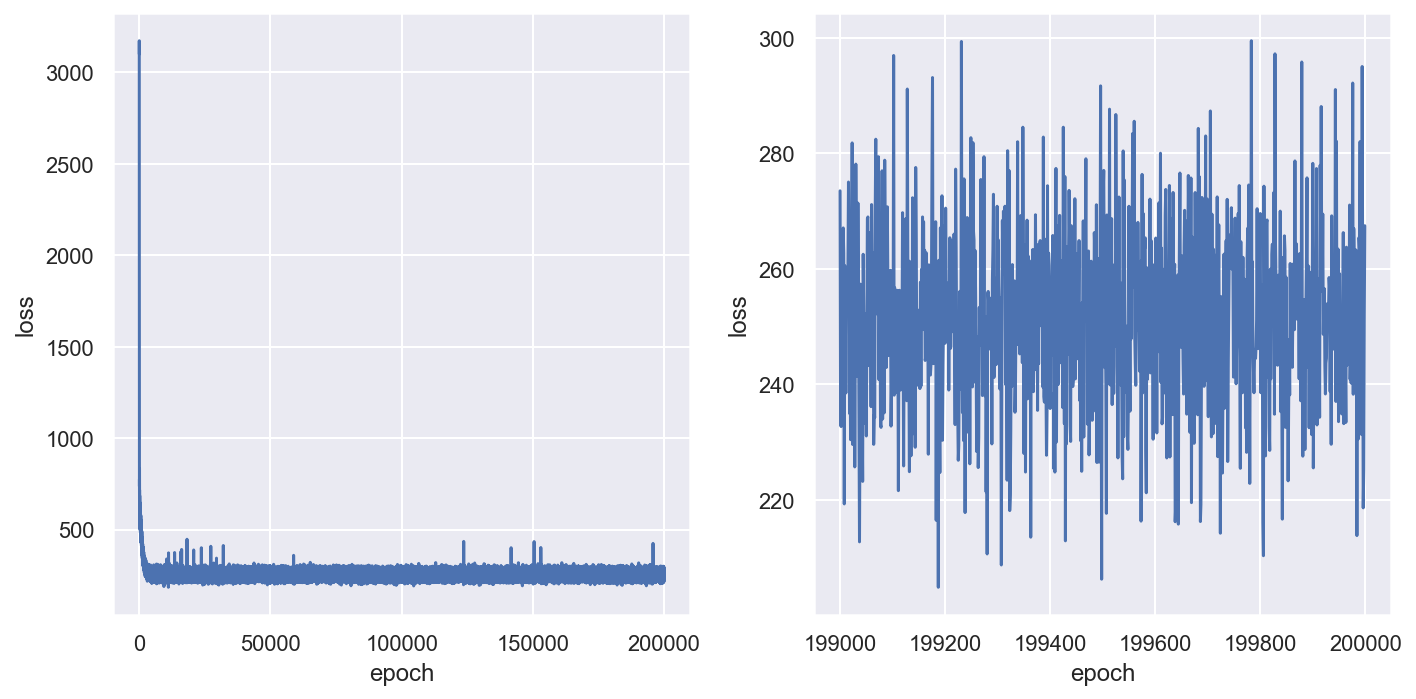

In [11]:
plot_loss(hist_loss)

# Test 3

# Test 4

In [41]:
def train_minibatch_schedule(
        data,
        n_epochs=5000,
        initial_lr=0.01,
        flow_length=16,
        n_sample=40,
        batch_size=None,
        constant_lr=False,
        optimizer_name="Adam",
        seed=123,
        online_plot=False, # Plot online losses
        online_plot_freq_update=None, # only matters if online_plot is true
        online_plot_max_n=None): # only matters if online_plot is true

    torch.manual_seed(seed)
    np.random.seed(seed)

    n_u = len(np.unique(data['u']))
    n_w = len(np.unique(data['w']))
    n_obs = len(data['u'])

    if batch_size is None:
        batch_size = n_obs

    z_flow = NormalizingFlow(dim=(n_u + n_w) * 2, flow_length=flow_length)
    theta_flow = NormalizingFlow(6, flow_length=flow_length)

    optimizer = getattr(torch.optim, optimizer_name)(
        list(z_flow.parameters()) + list(theta_flow.parameters()),
        lr=initial_lr)

    #if scheduler_name is not None:
    #    scheduler = getattr(torch.optim.lr_scheduler, scheduler_name)(optimizer)
    #    assert constant_lr is False
    #else:
    #    scheduler = None
    # scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min')
    
    loss_func = LossMinibatch()

    indices = np.arange(n_obs)

    with LossTracker(
            total=n_epochs,
            online_plot=online_plot,
            online_plot_freq_update=online_plot_freq_update,
            online_plot_max_n=online_plot_max_n) as loss_tracker:

        for epoch in range(n_epochs):

            np.random.shuffle(indices)

            for i in range(0, n_obs, batch_size):

                idx_minibatch = indices[i:i + batch_size]

                d = {k: v[idx_minibatch] for k, v in data.items()}

                optimizer.zero_grad()
                loss = loss_func(z_flow=z_flow,
                                 theta_flow=theta_flow,
                                 n_sample=n_sample,
                                 n_u=n_u, n_w=n_w,
                                 **d)
                loss.backward()
                optimizer.step()

                loss_tracker.append(loss.item())

                if constant_lr:
                    for g in optimizer.param_groups:
                        g['lr'] = initial_lr
            
#             if scheduler is not None:
#                 scheduler.step(loss)

            loss_tracker.update()

    return z_flow, theta_flow, loss_tracker.hist_loss


In [34]:
run_name = "artificial_minibatch_rmsprop_opt_test4"
z_flow, theta_flow, hist_loss = train_minibatch_schedule(
    data, 
    optimizer_name='RMSprop',
    batch_size=1000, 
    n_sample=50,
    initial_lr=0.001, 
    flow_length=33, 
    n_epochs=2000)

  0%|          | 0/2000 [00:00<?, ?it/s]

In [35]:
z_flow.save(run_name) 
theta_flow.save(run_name)

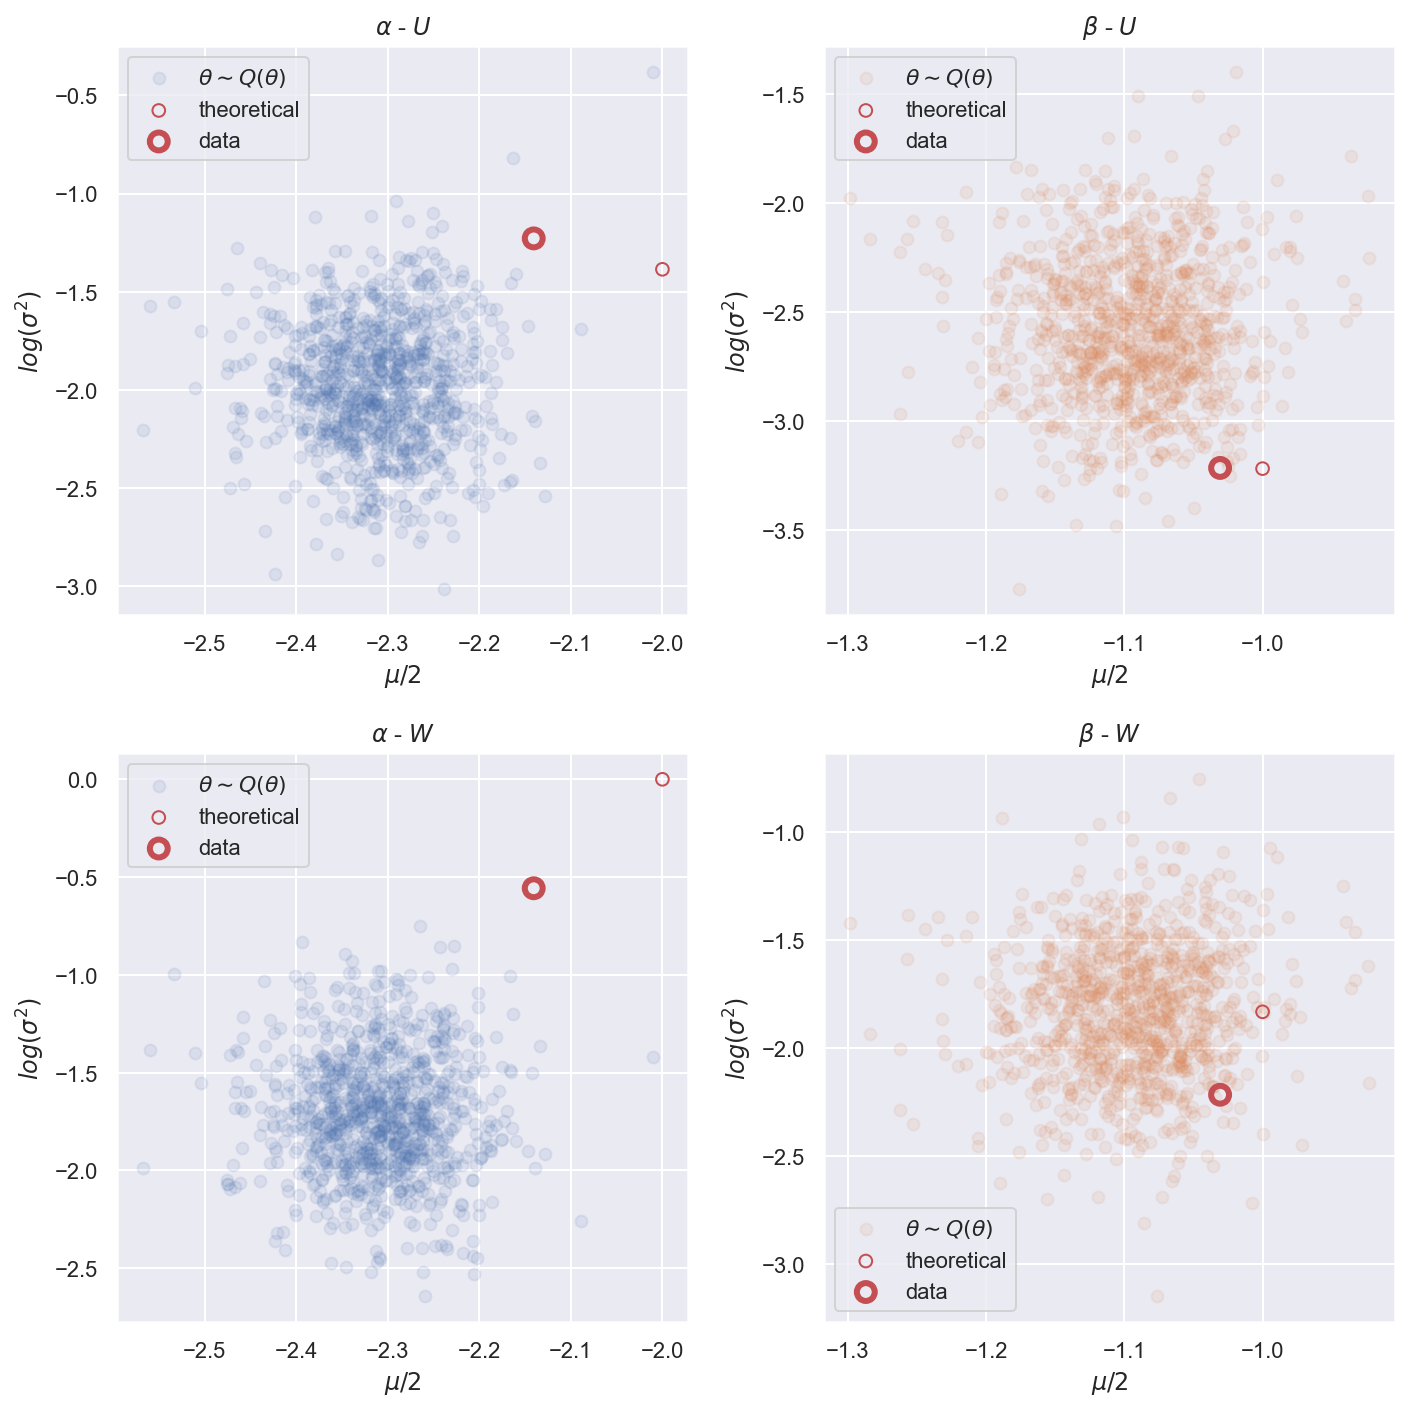

In [36]:
plot_posterior(theta_flow=theta_flow, 
               truth=truth, 
               name=run_name)

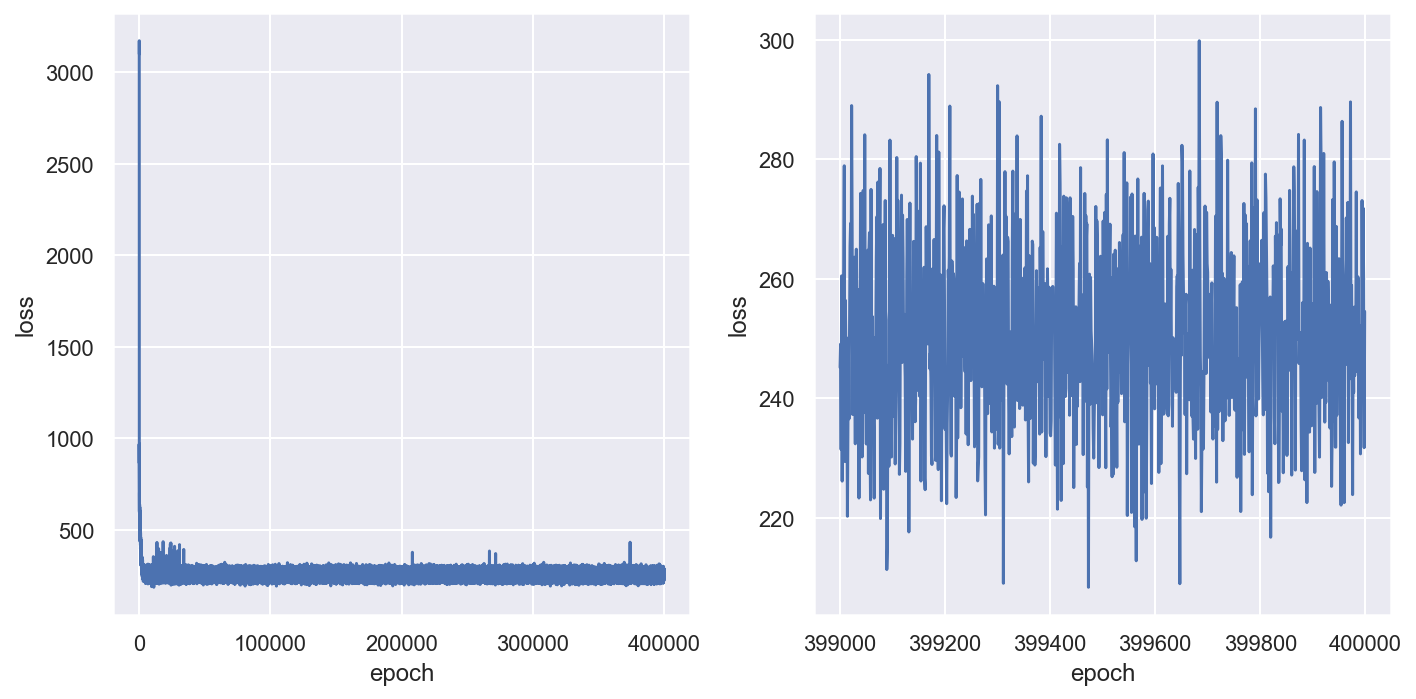

In [17]:
plot_loss(hist_loss)

# Test 5

In [42]:
run_name = "artificial_minibatch_rmsprop_opt_test5"
z_flow, theta_flow, hist_loss = train_minibatch_schedule(
    data, 
    optimizer_name='RMSprop',
    batch_size=1000, 
    n_sample=50,
    initial_lr=0.001, 
    flow_length=33, 
    n_epochs=200)

  0%|          | 0/200 [00:00<?, ?it/s]

In [35]:
z_flow.save(run_name) 
theta_flow.save(run_name)

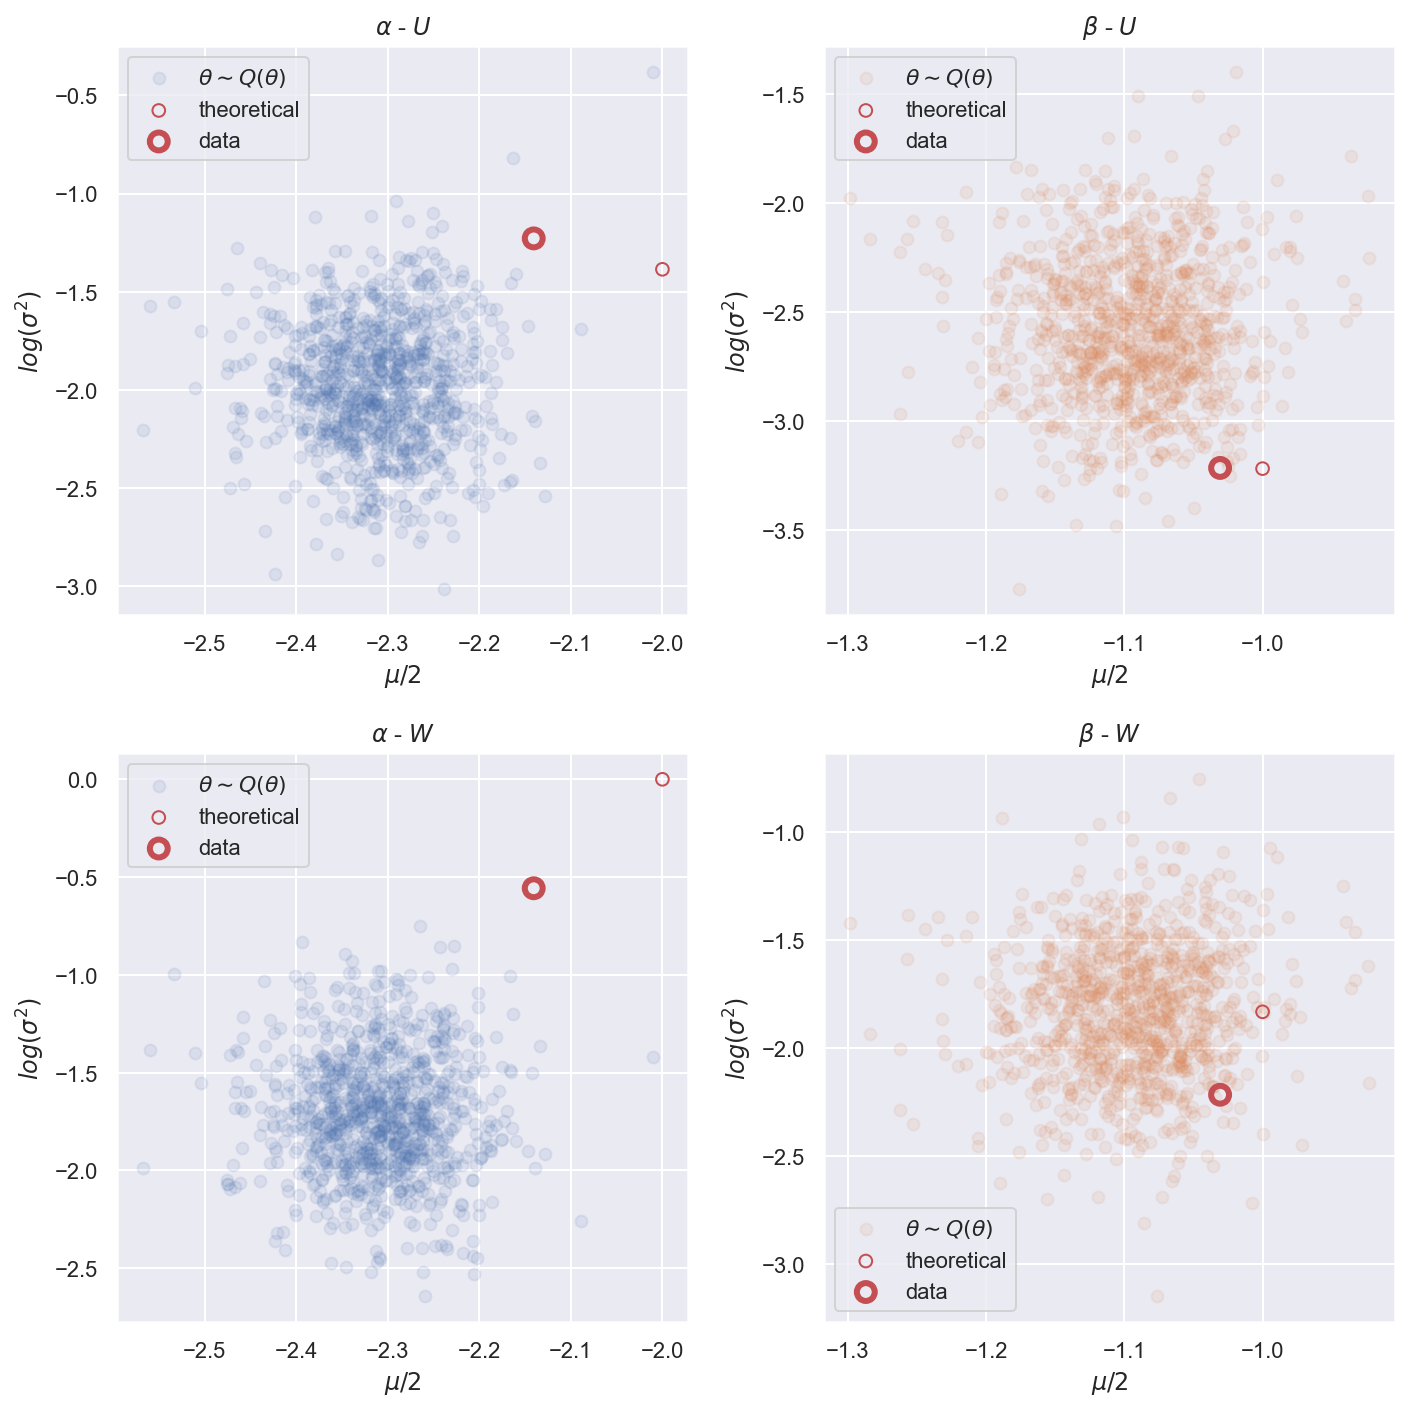

In [36]:
plot_posterior(theta_flow=theta_flow, 
               truth=truth, 
               name=run_name)

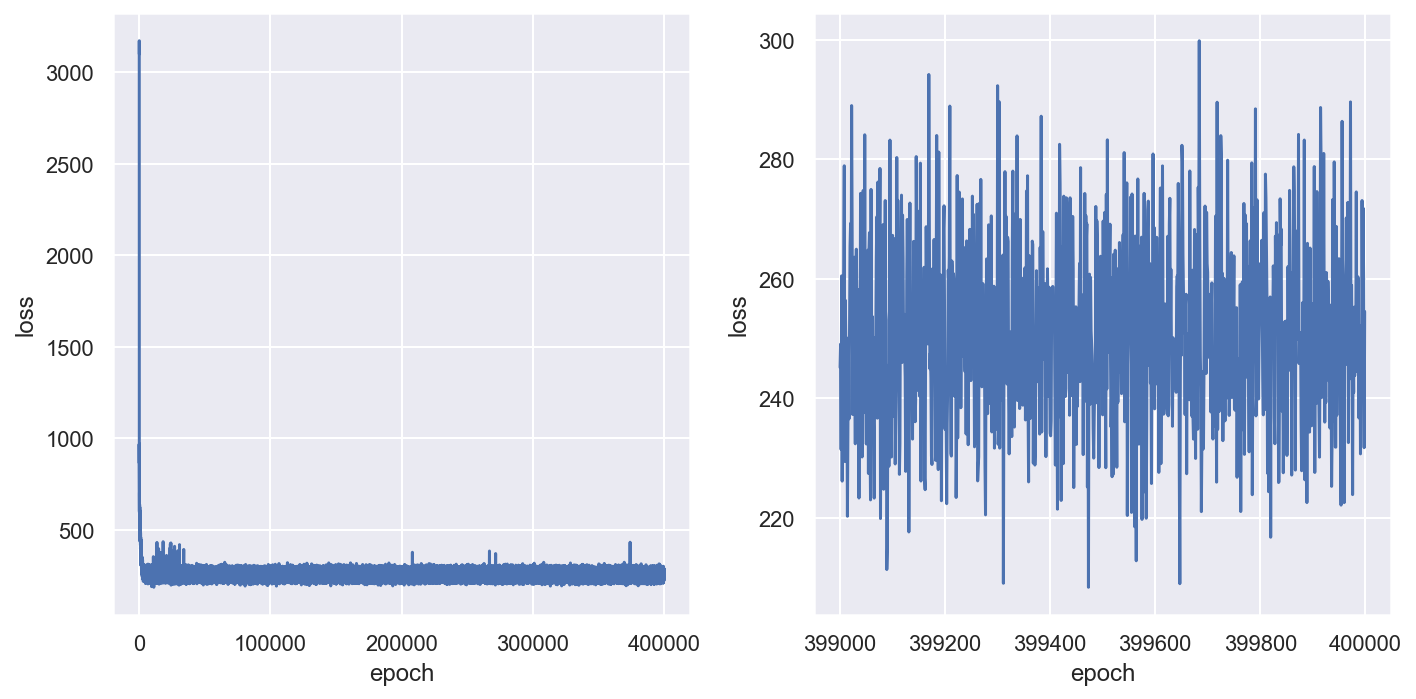

In [17]:
plot_loss(hist_loss)